In [60]:
from typing import List
import random
from copy import deepcopy

import import_ipynb
import GraphGenerator as gg

Graph with 23 nodes and 23 edges [12, 21, 10, 22] 16 3


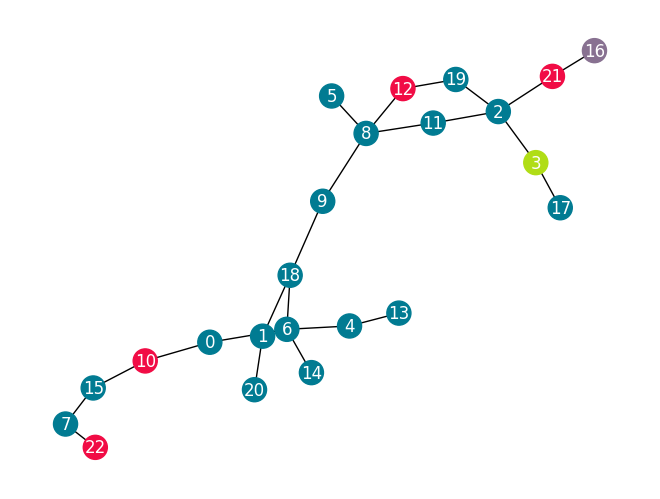

In [61]:
g, start_obstacles, start_pos, goal_pos = gg.build_graph()

In [62]:
def BFS(g, start_pos, goal_pos, obstacles):
    upcoming_nodes = [start_pos]
    parents = {}
    visited = set()
    
    while (len(upcoming_nodes) != 0):
        u = upcoming_nodes.pop(0)
        visited.add(u)
        if (u == goal_pos):
            return parents
        
        
        neighbors = [v for v in g[u] if obstacles[v] != 1 and v not in visited]
        if len(neighbors) == 0:
            continue
            
        for neighbor in neighbors:
            upcoming_nodes.append(neighbor)
            parents[neighbor] = u

    return None

# ## ISPIS BFS
# parents = BFS(g, start_pos, goal_pos, obstacles)
# current_node = goal_pos
# path = []
# if parents is not None:
#     while (current_node != start_pos):
#         path.append(current_node)
#         current_node = parents[current_node]
#     path.append(start_pos)
#     path.reverse()

# path

In [63]:
def printBFS(goal_pos, parents):
    current_node = goal_pos
    path = []
    if parents is not None:
        while (current_node != start_pos):
            path.append(current_node)
            current_node = parents[current_node]
        path.append(start_pos)
        path.reverse()

    print("Najkraci put ", path, ", duzina: ", len(path)-1)

In [64]:
def initialize(g, obstacles):
    solution = [True if i in obstacles else False for i in range(len(g.nodes))]
    return solution

In [65]:
def deinitialize(solution):
    solution_obstacles = []
    for i, k in enumerate(solution):
        if k:
            solution_obstacles.append(i)
    return solution_obstacles

In [66]:
def calc_solution_value(
    g,
    start_pos,
    goal_pos,
    solution: List[bool],
) -> int:

    # get path from BFS dictionary
    parents = BFS(g, start_pos, goal_pos, solution)
    current_node = goal_pos
    path = []
    if parents is not None:
        while (current_node != start_pos):
            path.append(current_node)
            current_node = parents[current_node]
        path.append(start_pos)
        path.reverse()
        
    
#     if len(path) > 0:
#         return len(path)-1
#     else:
#         return float('inf')
      
    return len(path)-1 if len(path)>0 else float('inf')

In [74]:
def move_obstacle(g, node, start_pos, goal_pos, solution, stuck_num):
#     possible_moves = sorted([node for node in g[node] if node not in obstacles and node != goal_pos and node != robot_pos])
    
    ## segFault
    if stuck_num == 50:
        return False, node, None
    
    possible_moves = sorted([v for v in g[node] if v != goal_pos and v != start_pos])
    if len(possible_moves) == 0:
        return False, node, None
        
    else:      
        chosen_move = random.sample(possible_moves, k = 1)[0]
        if(solution[chosen_move] == 1):
            #recursion
            return move_obstacle(g, chosen_move, start_pos, goal_pos, solution, stuck_num+1)
        
#         solution[node] = False
#         solution[chosen_move] = True

        # print(f'{node}->{chosen_move}')
        return True, chosen_move, node
        # print(f'{node} -> {chosen_move}')

In [75]:
def make_small_change(
    solution: List[bool],
    g,
    start_pos,
    goal_pos,
):
    new_solution = deepcopy(solution)
    obstacle_to_be_moved = random.sample(deinitialize(solution), k=1)[0]
    moved, dest, source = move_obstacle(g, obstacle_to_be_moved, start_pos, goal_pos, new_solution, stuck_num=0)
    if moved == True:
        new_solution[source] = False
        new_solution[dest] = True
#         print(f'{source} -> {dest}', end = " ")

    return new_solution

In [76]:
def simulated_annealing(g, start_pos, goal_pos, obstacles, num_iters):
    solution = initialize(g, obstacles)
    value = calc_solution_value(g, start_pos, goal_pos, solution)
    best_solution = deepcopy(solution)
    best_value = value
    obstacle_moves = 0
    best_obstacle_moves = obstacle_moves
    
#     values = [None for _ in range(num_iters)]
    for i in range(1, num_iters + 1):
        new_solution = make_small_change(solution, g, start_pos, goal_pos)
        obstacle_moves += 1
        new_value = calc_solution_value(g, start_pos, goal_pos, new_solution) + obstacle_moves
        
        if new_value < value:
            value = new_value
            solution = deepcopy(new_solution)
            if new_value < best_value:
                parents = BFS(g, start_pos, goal_pos, solution)
                printBFS(goal_pos, parents)
                
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_obstacle_moves = obstacle_moves
        else:
            if random.random() < 1 / i:
                value = new_value
                solution = deepcopy(new_solution)
            else:
                obstacle_moves -= 1
        
        
#         values[i - 1] = value
        
#     plt.plot(range(num_iters), values)

    obstaccles = []
    for i, k in enumerate(best_solution):
        if k:
            obstaccles.append(i)
    print("Najmanje pomeraja prepreka: ", best_obstacle_moves)
    print("Najbolje prepreke: ", obstaccles)
    print("Najbolji rezultat: ", best_value)
    
    return best_solution, best_value

In [83]:
obstacles = deepcopy(start_obstacles)
result, result_value = simulated_annealing(g, start_pos, goal_pos, obstacles, num_iters = 10000)
result_value

Najkraci put  [16, 21, 2, 3] , duzina:  3
Najmanje pomeraja prepreka:  2
Najbolje prepreke:  [10, 11, 12, 22]
Najbolji rezultat:  5


5

In [84]:
def shaking(g, solution, start_pos, goal_pos, k):
    obstacles_moved = 0
    new_solution = deepcopy(solution)
    obstacles_to_be_moved = random.sample(deinitialize(solution), k)
    for obstacle in obstacles_to_be_moved:
        moved, dest, source = move_obstacle(g, obstacle, start_pos, goal_pos, new_solution, stuck_num=0)
        if moved == True:
            new_solution[source] = False
            new_solution[dest] = True
            obstacles_moved += 1
    return new_solution, obstacles_moved

In [85]:
from time import perf_counter

In [86]:
def local_search_invert_first_improvement(
    g, start_pos, goal_pos, solution, value
):
    obstacle_moves = 0
    new_solution = deepcopy(solution)
    improved = True
    while improved:
        improved = False
        unbiased_order = deinitialize(new_solution)
        random.shuffle(unbiased_order)
        for i in unbiased_order:
            #move
            moved, dest, source = move_obstacle(g, i, start_pos, goal_pos, new_solution, stuck_num=0)
            if moved == True:
                new_solution[source] = False
                new_solution[dest] = True
                obstacle_moves += 1
            
            new_value = calc_solution_value(g, start_pos, goal_pos, new_solution) + obstacle_moves + value
            if new_value < value:
                value = new_value
                improved = True
                break
            else:
                if moved == True:
                    new_solution[source] = True
                    new_solution[dest] = False
                    obstacle_moves -= 1
            
    return new_solution, value


#     new_solution = deepcopy(solution)
#     improved = True
#     while improved:
#         improved = False
#         unbiased_order = list(range(len(solution)))
#         random.shuffle(unbiased_order)
#         for i in unbiased_order:
#             new_solution[i] = not new_solution[i]
#             new_value = calc_solution_value(new_solution, cost, facility_cost)
#             if new_value < value:
#                 value = new_value
#                 improved = True
#                 break
#             else:
#                 new_solution[i] = not new_solution[i]
#     return new_solution, value

In [91]:
def vns(g, start_pos, goal_pos, obstacles, vns_params: dict, num_iters):
    start_time = perf_counter()
    solution = initialize(g, obstacles)
    value = calc_solution_value(g, start_pos, goal_pos, solution)
    obstacle_moves = 0
    best_obstacle_moves = obstacle_moves
    
    for i in range(num_iters):
        for k in range(vns_params['k_min'], vns_params['k_max']): 
            #diverzifikacija
            new_solution, obstacles_moved = shaking(g, solution, start_pos, goal_pos, k)
            obstacle_moves += obstacles_moved
            # print(f'Obstacle moves se povecao na : {obstacle_moves}')
            new_value = calc_solution_value(g, start_pos, goal_pos, new_solution) + obstacle_moves
            # print(f'Vrednost solucije: {calc_solution_value(g, start_pos, goal_pos, new_solution)}, nakon dodavanja prepreka: {new_value}')
            
            #intenzifikacija
            new_solution, new_value = local_search_invert_first_improvement(g, start_pos, goal_pos, new_solution, new_value)
#             print(new_solution)
            if new_value < value or (new_value == value and random.random() < vns_params['move_prob']):
                # print(f'Vrednost new_value: {new_value}, vrednost value: {value}')
                value = new_value
                solution = deepcopy(new_solution)
                best_obstacle_moves = obstacle_moves
#             print(solution)
            else:
                obstacle_moves -= obstacles_moved
                # print(f'Obstacle moves se smanjio na : {obstacle_moves}')

    obstaccles = []
    for i, k in enumerate(solution):
        if k:
            obstaccles.append(i)
    

    print("Najmanje pomeraja prepreka: ", best_obstacle_moves)
    print("Najbolje prepreke: ", obstaccles)
    print("Najbolji rezultat: ", value)

    return solution, value

In [96]:
vns_params = {
    'time_limit': 2,
    'k_min': 1,
    'k_max': 3,
    'move_prob': 0.5,
}
obstacles = deepcopy(start_obstacles)
solution, value = vns(g, start_pos, goal_pos, obstacles, vns_params, num_iters = 10000)
print(value)

Najmanje pomeraja prepreka:  7
Najbolje prepreke:  [6, 7, 12, 19]
Najbolji rezultat:  10
10


In [689]:
print(start_obstacles)
print(obstacles)

[14, 4, 10, 8, 13, 20, 22, 3, 11]
[14, 4, 10, 8, 13, 20, 22, 3, 11]
